[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

# Filtering and trimming messages 过滤和修剪消息

## Review 回顾

现在，我们对以下几个方面有了更深入的理解：

* 如何自定义图状态模式  
* 如何定义自定义状态 reducers 
* 如何使用多个图状态模式  

## 目标

现在，我们可以开始在 LangGraph 中将这些概念与模型结合使用！

在接下来的几节中，我们将致力于构建一个具有**长期记忆**的聊天机器人。

由于我们的聊天机器人会使用 `messages` 功能，让我们先深入讨论一些在图状态中处理 `messages` 的高级方法。

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[追踪](https://docs.smith.langchain.com/concepts/tracing)。

我们将日志记录到项目 `langchain-academy` 中。

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

首先，让我们定义一些消息 messages。

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


回想一下，我们可以将它们传递给聊天模型。

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='Great question, Lance! Ocean mammals are a fascinating group of animals. Here are a few more ocean mammals you might want to learn about:\n\n1. **Dolphins**: These intelligent and social creatures are known for their playful behavior and complex communication skills. There are several species of dolphins, including the bottlenose dolphin and the common dolphin.\n\n2. **Porpoises**: Similar to dolphins but typically smaller and stouter, porpoises are less well-known but equally interesting. The harbor porpoise is one example.\n\n3. **Seals**: These include both true seals (like the harbor seal) and eared seals (which include sea lions and fur seals). They are known for their ability to live both in the water and on land.\n\n4. **Sea Lions**: These are a type of eared seal, easily recognized by their external ear flaps and their ability to "walk" on land using their large flippers.\n\n5. **Walruses**: Known for their distinctive long tusks and whiskers, walruses are so

我们可以在一个带有 `MessagesState` 的简单图中运行我们的聊天模型。

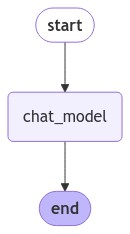

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Absolutely, whales are fascinating! But there are many other ocean mammals worth learning about. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species, including the bottlenose dolphin and the orca (killer whale), which is actually the largest member of the dolphin family.

2. **Seals and Sea Lions**: These pinnipeds are often found lounging on beaches or frolicking in the water. Seals tend to be more solitary, while sea lions are social and known for their barking calls.

3. **Man

## Reducer 缩减器

处理消息 messages 时，一个实际的挑战是管理长时间的对话。

如果不加注意，长时间的对话会导致高令牌使用量和延迟，因为我们会将不断增长的消息列表传递给模型。

我们有几种方法可以解决这个问题。

首先，回想一下我们之前看到的技巧：使用 `RemoveMessage` 和 `add_messages` 缩减器。

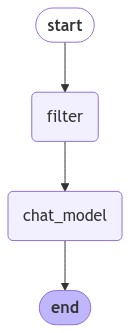

In [7]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are a variety of other fascinating ocean mammals you might be interested in learning about. Here are a few:

1. **Dolphins**: These highly intelligent and social animals are part of the cetacean family, which also includes whales and porpoises. There are many species of dolphins, including the common bottlenose dolphin and the orca, or killer whale, which is actually the largest member of the dolphin family.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and teeth. The harbor porpoise is one of the more well-known sp

## Filtering messages 筛选消息

如果您不需要或不想修改图状态 graph state，可以直接筛选传递给聊天模型的消息。

例如，只需传递一个经过筛选的列表：`llm.invoke(messages[-1:])` 给模型。

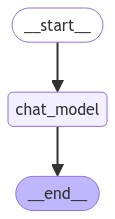

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

In [14]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

状态中包含了所有消息。

但让我们查看 LangSmith 的跟踪记录，看看**模型调用仅使用了最后一条消息**：

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

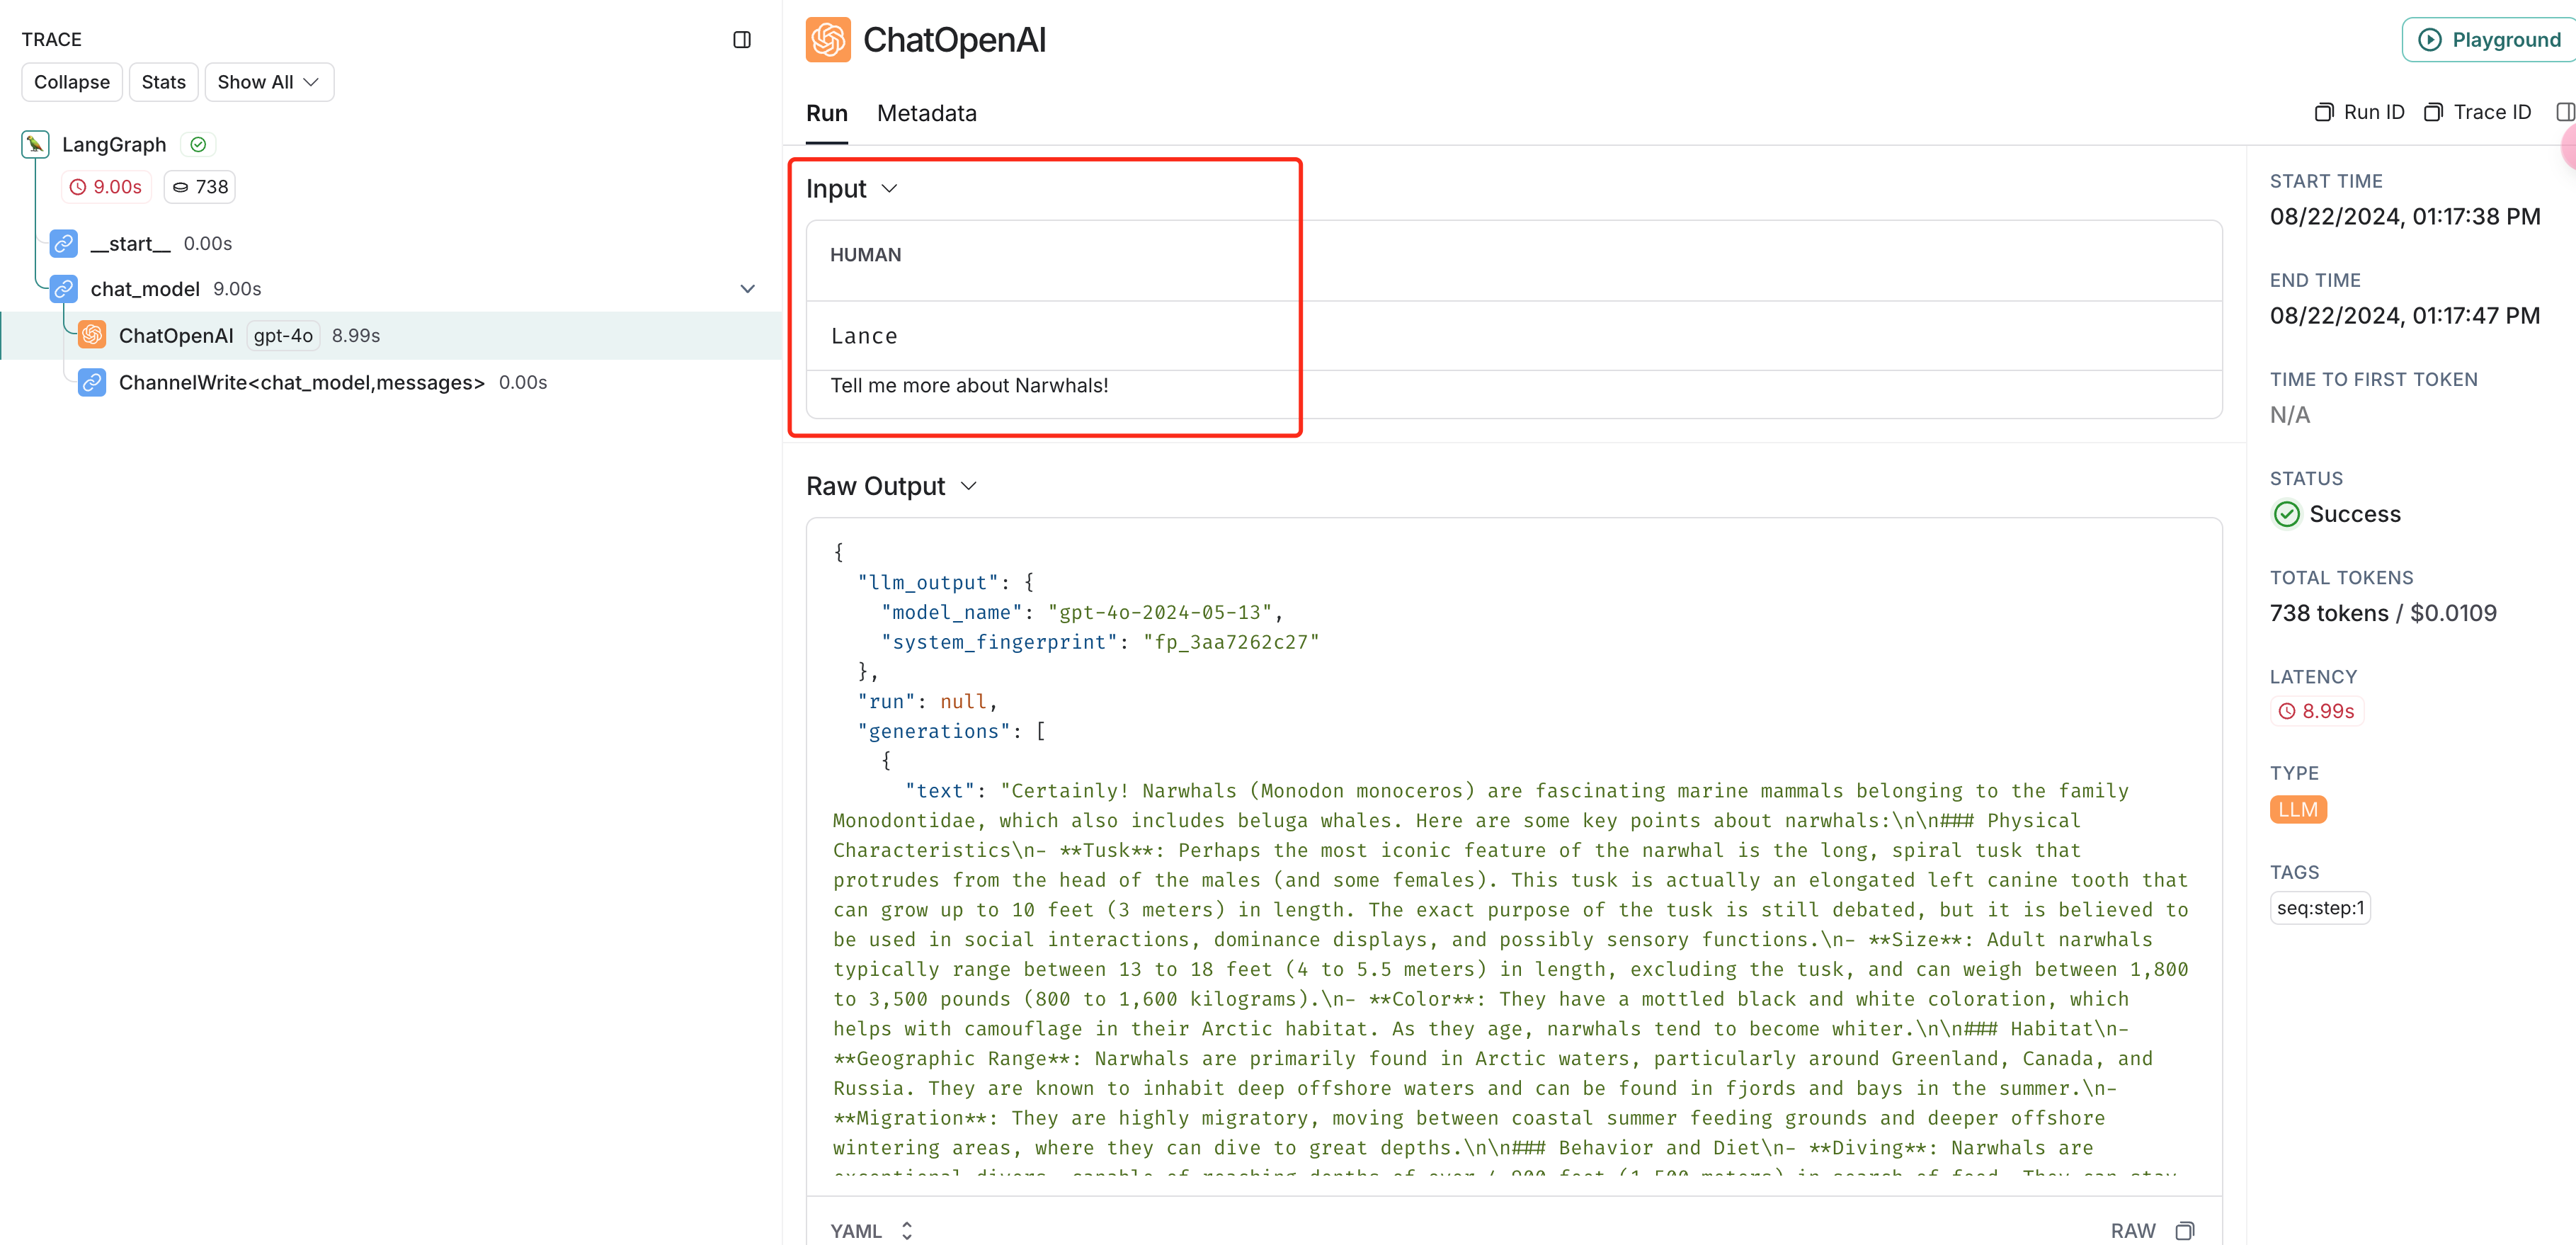

## Trim messages 修剪消息

另一种方法是基于设定的令牌数量，对[消息进行修剪](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens)。

这将消息历史限制为指定数量的令牌。

筛选仅返回代理之间消息的事后子集，而修剪则限制聊天模型可以用来响应的令牌数量。

请参阅下面的 `trim_messages`。


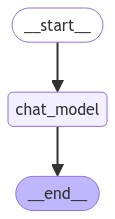

In [15]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [17]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [18]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

让我们查看 LangSmith 的跟踪记录，了解模型调用的情况：

[https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r](https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r)

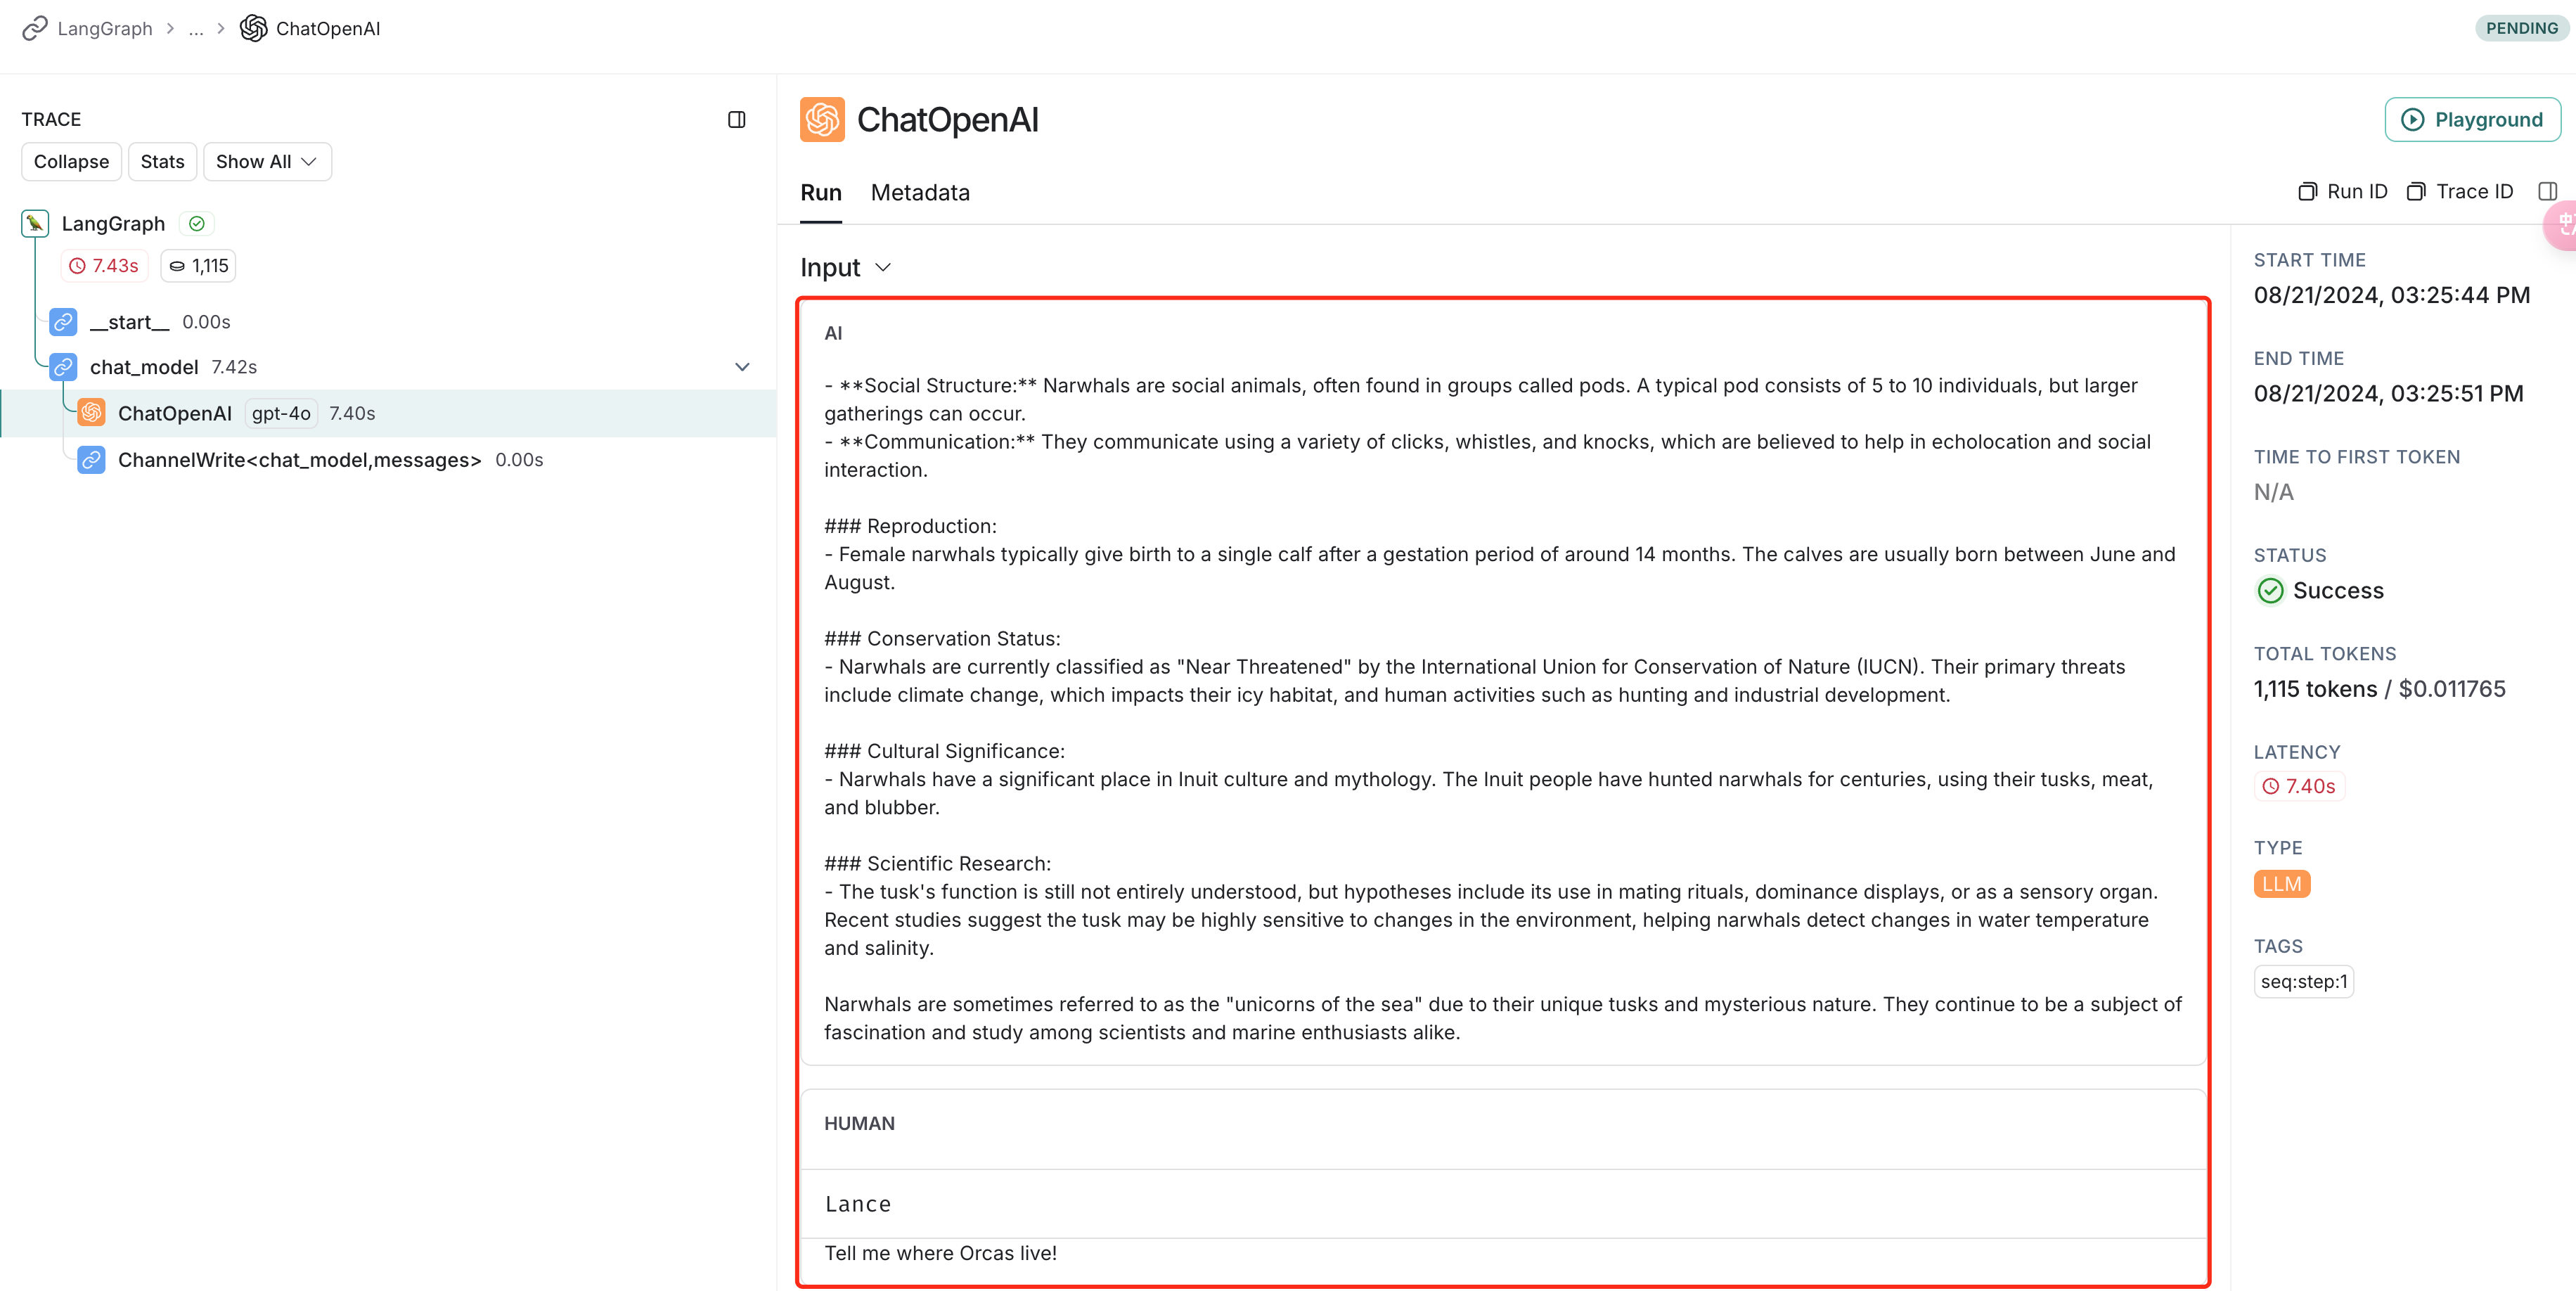

In [ ]:
# END